# Unit 3 final project
## Arutyunyan Vitaly (DST-11 Group-23)


# import

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import ast

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем инструменты для категориальных признаков
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 56

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
DATA_DIR = ''
df_train = pd.read_csv(DATA_DIR+'main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [9]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
4476,id_4476,Vienna,"['Italian', 'Austrian', 'European']",2519.0,$$ - $$$,17.0,"[['Good Pizza', 'good food, friendly staff'], ...",/Restaurant_Review-g190454-d2527913-Reviews-Da...,d2527913,0,0.0
21352,id_745,Dublin,"['Irish', 'Bar', 'European', 'Pub', 'Gastropub...",746.0,$$ - $$$,102.0,"[['Always Reliable', 'Breakfast wonder'], ['01...",/Restaurant_Review-g186605-d1951350-Reviews-Th...,d1951350,1,4.0
18726,id_951,Geneva,"['Japanese', 'Sushi', 'Asian', 'Vegetarian Fri...",956.0,$$ - $$$,109.0,"[['Good quality, ample staffing', 'Good place ...",/Restaurant_Review-g188057-d776624-Reviews-Sag...,d776624,1,3.5
47144,id_5374,Rome,NaN,5376.0,NaN,35.0,"[['Excellent place to chill', 'Cool bar in the...",/Restaurant_Review-g187791-d4794288-Reviews-Li...,d4794288,1,3.5
17110,id_2103,Lisbon,"['European', 'Portuguese']",2106.0,$$ - $$$,3.0,"[['Familiar restaurante with home made food'],...",/Restaurant_Review-g189158-d10246239-Reviews-R...,d10246239,1,5.0


In [10]:
#data.Reviews[27832]

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## Очистка и подготовка данных

### Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [11]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

### ****(new) Country****

In [12]:
# Определение страны ресторана

countries_dict = {
    'London': 'England',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Amsterdam': 'Holland',
    'Brussels': 'Belgium',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Romania',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland',
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Scotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugal',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenia'
}
data['Country'] = data['City'].map(countries_dict)

countries_labels = LabelEncoder()
countries_labels.fit(data['Country'])
data['country code'] = countries_labels.transform(data['Country'])

### (new) Capital city (является ли город столицей)

In [13]:
is_capital = {
    'London': 1,
    'Paris' : 1,
    'Madrid': 1,
    'Barcelona': 0,
    'Berlin': 1,
    'Milan': 0,
    'Rome': 1,
    'Prague': 1,
    'Lisbon': 1,
    'Vienna': 1,
    'Amsterdam': 1,
    'Brussels': 1,
    'Hamburg': 0,
    'Munich': 0,
    'Lyon': 0,
    'Stockholm': 1,
    'Budapest': 1,
    'Warsaw': 1,
    'Dublin': 1,
    'Copenhagen': 1,
    'Athens': 1,
    'Edinburgh': 1,
    'Zurich': 1,
    'Oporto': 0,
    'Geneva': 1,
    'Krakow': 0,
    'Oslo': 1,
    'Helsinki': 1,
    'Bratislava': 1,
    'Luxembourg': 1,
    'Ljubljana': 1
}

data['is capital'] = data['City'].map(is_capital)

### (new) Population of city

In [14]:
population = {
    'London': 8908081,
    'Paris' : 2148327,
    'Madrid': 3223334,
    'Barcelona': 1620343,
    'Berlin': 3769495,
    'Milan': 1378689,
    'Rome': 2870500,
    'Prague': 1324277,
    'Lisbon': 505526,
    'Vienna': 1897491,
    'Amsterdam': 857713,
    'Brussels': 179277,
    'Hamburg': 1899160,
    'Munich': 1471508,
    'Lyon': 513275,
    'Stockholm': 975904,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 794128,
    'Athens': 664046,
    'Edinburgh': 488100,
    'Zurich': 415215,
    'Oporto': 214349,
    'Geneva': 201818,
    'Krakow': 769498,
    'Oslo': 681067,
    'Helsinki': 650058,
    'Bratislava': 437725,
    'Luxembourg': 613894,
    'Ljubljana': 284355
}
data['population of city'] = data['City'].map(population)

### (new) Count restaurants in city

In [15]:
r_count = data.groupby('City')['Restaurant_id'].count().to_dict()
# print(r_count)
data['Count rest in city'] = data['City'].map(r_count)

### (new) Relative ranking

In [16]:
data['ralative ranking'] = data['Ranking'] / data['Count rest in city']

### (new) Population on restaurant

In [17]:
data['population_on_rest'] = data['population of city'] / data['Count rest in city']

In [18]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Country,country code,is capital,population of city,Count rest in city,ralative ranking,population_on_rest
45055,id_1320,Paris,"['Japanese', 'Asian', 'Fusion']",1321.0,$$$$,331.0,"[['A fantastic trip to fusion Japan', 'Yummy']...",/Restaurant_Review-g187147-d1050722-Reviews-GU...,d1050722,1,4.5,France,6,1,2148327,6108,0.216274,351.723477
6928,id_6928,Amsterdam,"['Bar', 'International', 'Pub', 'Vegetarian Fr...",360.0,$,116.0,"[['Best bar in Amsterdam', 'Best pub in Amster...",/Restaurant_Review-g188590-d11949427-Reviews-C...,d11949427,0,0.0,Holland,9,1,857713,1372,0.262391,625.155248
8460,id_8460,Paris,NaN,10655.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187147-d5965095-Reviews-Ga...,d5965095,0,0.0,France,6,1,2148327,6108,1.744434,351.723477
41280,id_1367,Warsaw,"['Bar', 'European', 'Pub']",1369.0,$$ - $$$,50.0,"[['Best pizza in Warsaw', 'A forgettable pub']...",/Restaurant_Review-g274856-d753407-Reviews-Zie...,d753407,1,3.5,Poland,14,1,1790658,925,1.480000,1935.846486
15302,id_2763,Milan,"['Italian', 'Mediterranean']",2765.0,$$ - $$$,144.0,"[['Near Duomo', 'Good Enough But Expected More...",/Restaurant_Review-g187849-d1024678-Reviews-Ca...,d1024678,1,3.5,Italy,11,0,1378689,2694,1.026355,511.762806


In [19]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [20]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
11203,id_4972,['Italian'],4973.0,$,24.0,"[['Great breakfast!', 'Great local cofee!'], [...",/Restaurant_Review-g187791-d6090555-Reviews-Ca...,d6090555,1,4.5,...,0,0,0,0,1,0,0,0,0,0
328,id_328,"['French', 'Mexican', 'Healthy', 'International']",728.0,$,85.0,"[['Exquisite spontaneous lunch', 'Good quality...",/Restaurant_Review-g187514-d7258778-Reviews-So...,d7258778,0,0.0,...,0,0,0,0,0,0,0,0,0,0
31384,id_175,"['Mediterranean', 'European', 'Portuguese', 'W...",176.0,$$ - $$$,501.0,"[['Nice place for evening chill', 'Wonderful e...",/Restaurant_Review-g189158-d4745119-Reviews-Be...,d4745119,1,4.5,...,0,0,0,0,0,0,0,0,0,0
23434,id_1120,NaN,1122.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274856-d12926154-Reviews-G...,d12926154,1,5.0,...,0,0,0,0,0,0,0,1,0,0
45757,id_4192,"['Italian', 'Cafe']",4195.0,$,24.0,"[['Lunch and Learn', 'Little cafe'], ['06/21/2...",/Restaurant_Review-g187849-d4752526-Reviews-Da...,d4752526,1,4.0,...,0,0,0,0,0,0,0,0,0,0


### Cuisine Style

In [22]:
# Признак имеет 23.18% пропусков
# сохраним эту информацию
data['NaN_Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('float64')

# Можно закполнить пропуски значением 'Empty'
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")



In [23]:
def transform_to_list(data_string):
    result = ast.literal_eval(data_string)
    return result

data['cuisine_style_list'] = data['Cuisine Style'].apply(transform_to_list);

In [24]:
# print(data[data['Restaurant_id'] == '16846']['Cuisine Style'])

In [25]:
# data = pd.get_dummies(data, columns=[ 'Cuisine Style',], dummy_na=True)
#data.sample(5)

In [26]:
# newList = ['1', '2', '3']
# print('1' in newList)
# # data['Bar'] = data.apply()
# data['Bar'] = data['cuisine_style_list'].apply(lambda x: 1 if 'Bar' in x else 0)
# data.sample(5)

In [27]:
# создание dummy variables для cuisine style из списка кухонь

cuisines = data['cuisine_style_list']
cuisine_all_count = []
cuisines_all = dict()
for c_list in cuisines:
    cuisine_all_count.append(len(c_list))
    for cuisine in c_list:
        try:
            cuisines_all[cuisine] += 1
        except:
            cuisines_all[cuisine] = 1

# print(cuisines_all)
# print(len(cuisines_all))
for item in cuisines_all:
    data[item] = data['cuisine_style_list'].apply(lambda x: 1 if item in x else 0)
#     print(item)


In [28]:
# data = pd.get_dummies(data, columns=[ 'cuisine_style_list',], dummy_na=True)
# data['Cuisine_Count'] = data['Cuisine Style'].apply(lambda x: len(x)).astype('float64')
# data['Cuisine_Count_List'] = data['cuisine_style_list'].apply(lambda x: len(x)).astype('float64')
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
8270,id_8270,['Other'],7965.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187147-d12995013-Reviews-P...,d12995013,0,0.0,...,0,0,0,0,0,0,0,0,0,0
37221,id_742,"['French', 'European', 'Vegetarian Friendly', ...",743.0,$$ - $$$,523.0,"[['Reasonable Price for Paris', 'Good value, G...",/Restaurant_Review-g187147-d2420922-Reviews-L_...,d2420922,1,4.0,...,0,0,0,0,0,0,0,0,0,0
36292,id_2178,"['Bar', 'Spanish', 'Mediterranean']",2179.0,$,212.0,"[['Peaceful Night in the Harbor', 'Fast and go...",/Restaurant_Review-g187497-d6995961-Reviews-La...,d6995961,1,4.0,...,0,0,0,0,0,0,0,0,0,0
20758,id_322,"['Bar', 'European', 'Pub', 'Eastern European',...",323.0,$,300.0,"[['Local place with really good local food', '...",/Restaurant_Review-g274887-d2175651-Reviews-Pe...,d2175651,1,4.0,...,0,0,0,0,0,0,0,0,0,0
12858,id_2285,"['European', 'Swedish']",2289.0,NaN,7.0,"[['There are other places to go'], ['11/09/201...",/Restaurant_Review-g189852-d10301915-Reviews-R...,d10301915,1,3.0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 177 entries, Restaurant_id to Latvian
dtypes: float64(6), int32(1), int64(130), object(8), uint8(32)
memory usage: 56.6+ MB


### Price Range

In [30]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [31]:
# Обработка 'Price Range'
# сохранение информации о пропусках, чтобы не потерять
data['NaN_Price_Range'] = pd.isna(data['Price Range']).astype('float64')

# В признаке очень много пропусков 34.7%
# Заполним эти пропуски значением $$ - $$$
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

# Признак Price Range можно перевести в числовой вид
price_values_dict = {
    '$': 1,
    '$$ - $$$': 2,
    '$$$$': 3
}
data['Price Range'] = data['Price Range'].map(lambda x: price_values_dict.get(x, x))

In [32]:
data['Price Range'].value_counts()

2    40402
1     7816
3     1782
Name: Price Range, dtype: int64

### Number of Reviews

In [33]:
# В признаке 6.4% пропущенных значений
# сохраним эту информацию
data['NaN_Number of reviews'] = pd.isna(data['Number of Reviews']).astype('float64')

# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)


data['Reviews'].fillna("[[], []]", inplace=True)

def transform_to_list_reviews(list_string):
    list_string = list_string.replace('nan]', "'This is Nan']")
    list_string = list_string.replace('[nan', "['This is Nan'")
    result_list = ast.literal_eval(list_string)
    return result_list

# transform reviews to list
data['reviews_list'] = data['Reviews'].apply(transform_to_list_reviews)

In [34]:
# calculate days between reviews

from datetime import datetime

def delta_between_reviews(row):
    if len(row[1]) == 0 or len(row[1]) == 1:
        return 0
    
    elif len(row[1]) == 2:
        date1 = datetime.strptime(row[1][0],'%m/%d/%Y')
        date2 = datetime.strptime(row[1][1],'%m/%d/%Y')
        return abs(date1 - date2).days

data['Days between reviews'] = data['reviews_list'].apply(delta_between_reviews)

In [35]:
#data.sample(5)

In [36]:
# reviews count
data['Reviews count'] = data['reviews_list'].apply(lambda x: len(x[0]))
#data.sample(5)

### -------------------------
### Model fit

In [37]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

df_preproc = data
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,country code,is capital,population of city,Count rest in city,ralative ranking,...,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,NaN_Price_Range,NaN_Number of reviews,Days between reviews,Reviews count
12199,14895.0,1,46.0,1,3.5,4,1,8908081,7193,2.070763,...,0,0,0,0,0,0,0.0,0.0,59,2
2798,177.0,1,99.0,0,0.0,8,1,664046,776,0.228093,...,0,0,0,0,0,0,0.0,0.0,29,2
17653,5082.0,1,3.0,1,2.5,11,0,1378689,2694,1.886414,...,0,0,0,0,0,0,0.0,0.0,0,0
7900,2132.0,1,8.0,0,0.0,9,1,857713,1372,1.553936,...,0,0,0,0,0,0,0.0,0.0,62,2
25138,6747.0,1,4.0,1,5.0,20,0,1620343,3395,1.987334,...,0,0,0,0,0,0,0.0,0.0,0,1
43693,2574.0,2,555.0,1,3.5,6,1,2148327,6108,0.421415,...,0,0,0,0,0,0,0.0,0.0,2,2
12232,4572.0,3,66.0,1,4.0,4,1,8908081,7193,0.635618,...,0,0,0,0,0,0,0.0,0.0,292,2
14936,14197.0,2,199.0,1,3.5,4,1,8908081,7193,1.973724,...,0,0,0,0,0,0,0.0,0.0,40,2
34956,369.0,3,423.0,1,4.0,15,1,505526,1647,0.224044,...,0,0,0,0,0,0,0.0,0.0,10,2
18358,4582.0,2,2.0,1,4.5,7,1,3769495,2705,1.693900,...,0,0,0,0,0,0,1.0,0.0,0,1


In [38]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [39]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [40]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 173), (40000, 173), (40000, 172), (32000, 172), (8000, 172))

In [41]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [42]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [43]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


RandomForestRegressor(n_jobs=-1, random_state=56, verbose=1)

In [44]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])

y_pred = predict(X_test)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished


In [45]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1743125


<AxesSubplot:>

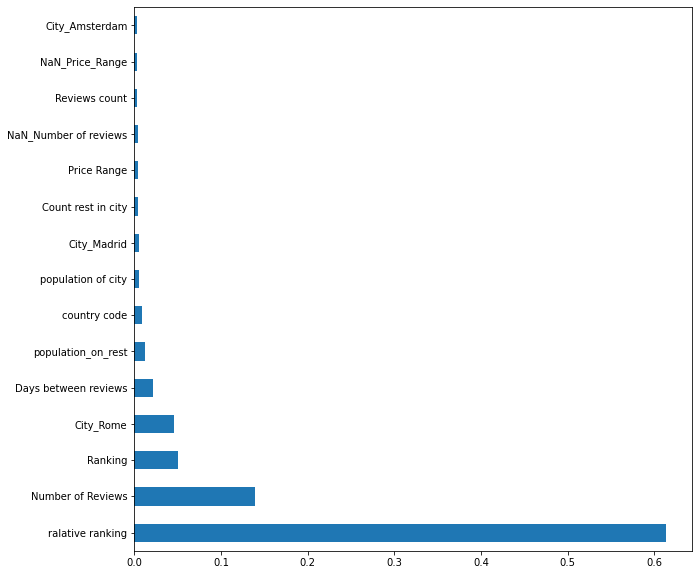

In [46]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [47]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,country code,is capital,population of city,Count rest in city,ralative ranking,population_on_rest,...,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,NaN_Price_Range,NaN_Number of reviews,Days between reviews,Reviews count
9608,1779.0,2,0.0,0.0,0,1,1897491,1443,1.232848,1314.962578,...,0,0,0,0,0,0,1.0,1.0,0,0
123,4984.0,2,2.0,0.0,20,1,3223334,3813,1.307107,845.353790,...,0,0,0,0,0,0,1.0,0.0,0,0
6034,1679.0,2,342.0,0.0,4,1,8908081,7193,0.233421,1238.437509,...,0,0,0,0,0,0,0.0,0.0,12,2
6148,1098.0,2,11.0,0.0,16,1,1752286,1021,1.075416,1716.244858,...,0,0,0,0,0,0,1.0,0.0,62,2
3058,8366.0,2,2.0,0.0,6,1,2148327,6108,1.369679,351.723477,...,0,0,0,0,0,0,1.0,0.0,0,1
1957,5092.0,2,0.0,0.0,7,1,3769495,2705,1.882440,1393.528651,...,0,0,0,0,0,0,1.0,1.0,0,0
1096,13215.0,2,8.0,0.0,4,1,8908081,7193,1.837203,1238.437509,...,0,0,0,0,0,0,0.0,0.0,78,2
6858,3511.0,2,13.0,0.0,2,1,1324277,1816,1.933370,729.227423,...,0,0,0,0,0,0,1.0,0.0,17,2
4136,2722.0,3,26.0,0.0,11,1,2870500,2589,1.051371,1108.729239,...,0,0,0,0,0,0,0.0,0.0,19,2
4419,1328.0,2,2.0,0.0,22,1,201818,590,2.250847,342.064407,...,0,0,0,0,0,0,1.0,0.0,0,0


In [48]:
test_data = test_data.drop(['Rating'], axis=1)

In [49]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [50]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished


In [51]:
predict_submission

array([3.065, 4.215, 4.45 , ..., 3.015, 4.33 , 4.34 ])

In [52]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.065
1,id_1,4.215
2,id_2,4.450
3,id_3,4.415
4,id_4,4.500
5,id_5,4.510
6,id_6,1.560
7,id_7,2.935
8,id_8,4.210
9,id_9,4.575


### --

-----------------
-----------------

############################
############################
############################

####################################################################

###############################################################

### FROM OLD NOTEBOOK
FOR EXAMPLE

### Посмотрим распределение признака

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [ ]:
data.groupby(['City'])['Ranking'].mean()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [ ]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

In [ ]:
df_preproc.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
